In [1]:
import pandas as pd
import hddm
import numpy as np
import os

data = hddm.load_csv('data_preprocessed.csv', index_col=0)

/anaconda3/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


In [2]:
data.head()

,subj_idx,response,rt,gain,loss
0,1,1.0,2.388,14,-6
1,1,1.0,2.289,34,-14
2,1,1.0,1.873,34,-13
3,1,0.0,1.457,10,-10
4,1,0.0,1.973,12,-19


In [3]:
m = hddm.models.HDDMRegressor(data, ['v ~ gain + loss'], include=('z'), group_only_regressors=False)

Adding these covariates:
['v_Intercept', 'v_gain', 'v_loss']


In [4]:
m.find_starting_values()

/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1934: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/anaconda3/lib/python2.7/site-packages/scipy/optimize/optimize.py:1935: RuntimeWarning: invalid value encountered in double_scalars
  p = (x - v) * tmp2 - (x - w) * tmp1


In [12]:
if not os.path.exists('savedModels/fullModel'):
    os.makedirs('savedModels/fullModel')

m.sample(5000, burn=1000, dbname='savedModels/fullModel/db_fullModel', db='pickle')

 [-----------------100%-----------------] 5001 of 5000 complete in 12330.8 sec

In [13]:
m.save('savedModels/fullModel/fullModel')

In [3]:
m = hddm.load('savedModels/fullModel/fullModel')

## Model parameters

In [14]:
m.print_stats()

                           mean         std       2.5q        25q        50q         75q      97.5q       mc err
a                       2.59984   0.0560709     2.4911    2.56265    2.59916     2.63579    2.71252   0.00112139
a_std                  0.386578   0.0426853   0.313271   0.356826    0.38314     0.41351   0.477034  0.000946858
a_subj.1                2.53584    0.116599    2.31405    2.45687    2.53407     2.61089    2.77324   0.00330256
a_subj.3                 2.8902    0.123088     2.6558    2.80739    2.88518     2.97065    3.14875   0.00324421
a_subj.5                2.11966   0.0721032    1.98496    2.06856    2.11928     2.16766    2.26609   0.00201504
a_subj.9                2.80845    0.127137    2.57544    2.72079    2.80295     2.89491    3.06015   0.00514537
a_subj.11               2.44423    0.130882    2.20531    2.35133    2.43693     2.53097    2.71376   0.00488953
a_subj.13               1.76046    0.086268    1.60075    1.69928    1.75648     1.81795    1.93

$\lambda$

In [4]:
import numpy as np

In [5]:
modelParamsDF = m.nodes_db
# modelParamsDF.to_csv("fullModel_params.csv")

# group level mean of lambda
groupLevelMeanOfLambda = modelParamsDF.loc['v_loss', 'mean']/modelParamsDF.loc['v_gain', 'mean']
print("group level mean of lamdba is: ", groupLevelMeanOfLambda)

# 95% CI for beta_G, beta_L
print("2.5% percentile for beta_L: ", modelParamsDF.loc['v_loss', '2.5q'])
print("97.5% percentile for beta_G: ", modelParamsDF.loc['v_gain', '97.5q'])

('group level mean of lamdba is: ', 1.604576723390229)
('2.5% percentile for beta_L: ', 0.14945612956648546)
('97.5% percentile for beta_G: ', 0.11100270197825084)


In [6]:
allSubjectsIndex = list(set(data['subj_idx']))
print(allSubjectsIndex)
totalNumSubjects = len(allSubjectsIndex)
print(totalNumSubjects)

[1, 3, 5, 9, 11, 13, 15, 17, 19, 21, 25, 27, 29, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 93, 95, 99, 103, 105, 107, 109, 113, 115, 117, 119, 121, 123]
54


In [7]:
# how many participants have beta_L > beta_G, how many have the 95% CI greater?
# participant level mean (SD) of lambda
numLambdaMean = 0
numLambdaCI = 0
allParticipantLambdas = []

for subjectIndex in allSubjectsIndex:
    beta_gain = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), 'mean']
    beta_loss = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), 'mean']
    beta_L_lowerBound = modelParamsDF.loc['v_loss_subj.{}'.format(subjectIndex), '2.5q']
    beta_G_upperBound = modelParamsDF.loc['v_gain_subj.{}'.format(subjectIndex), '97.5q']
    
    if beta_loss > beta_gain:
        numLambdaMean += 1
        
    if beta_L_lowerBound > beta_G_upperBound:
        numLambdaCI += 1
        
    lambdaForThisParticipant = beta_loss/beta_gain
    allParticipantLambdas.append(lambdaForThisParticipant)

print("Number of people with beta_L > beta_G = ", numLambdaMean)
# print("Number of people with 95% CI of beta_L > beta_G = ", numLambdaCI)
print("Average lambda over all individuals = {} ({})".format(np.mean(allParticipantLambdas), np.std(allParticipantLambdas)))

('Number of people with beta_L > beta_G = ', 52)
Average lambda over all individuals = 1.72243246425 (0.573804654686)


In [8]:
print("beta_L mean:", modelParamsDF.loc['v_loss', 'mean'])
print("beta_L 2.5q:", modelParamsDF.loc['v_loss', '2.5q'])
print("beta_L 97.5q:", modelParamsDF.loc['v_loss', '97.5q'])
print("beta_L median", modelParamsDF.loc['v_loss', '50q'])
print("beta_L SD", modelParamsDF.loc['v_loss', 'std'])

print("beta_G mean:", modelParamsDF.loc['v_gain', 'mean'])
print("beta_G 2.5q:", modelParamsDF.loc['v_gain', '2.5q'])
print("beta_G 97.5q:", modelParamsDF.loc['v_gain', '97.5q'])
print("beta_G median", modelParamsDF.loc['v_gain', '50q'])
print("beta_G SD", modelParamsDF.loc['v_gain', 'std'])

('beta_L mean:', 0.16215486552443628)
('beta_L 2.5q:', 0.14945612956648546)
('beta_L 97.5q:', 0.17525961124209513)
('beta_L median', 0.16208922191612019)
('beta_L SD', 0.006752942231573373)
('beta_G mean:', 0.10105772018294486)
('beta_G 2.5q:', 0.0910678204381988)
('beta_G 97.5q:', 0.11100270197825084)
('beta_G median', 0.10117172335263551)
('beta_G SD', 0.005250946218172144)


$\gamma$

In [9]:
meanA = modelParamsDF.loc['a', 'mean']
print("mean value of threshold: ", meanA)

# 95 CI interval
Z_CI_lowerBound = (modelParamsDF.loc['z'.format(subjectIndex), '2.5q'] - 0.5)*meanA
Z_CI_upperBound = (modelParamsDF.loc['z'.format(subjectIndex), '97.5q'] - 0.5)*meanA
print("confidence interval of gamma: ", Z_CI_lowerBound, Z_CI_upperBound)

('mean value of threshold: ', 2.5998392592020863)
('confidence interval of gamma: ', -0.011483502733529542, 0.06848652965023072)


In [10]:
# mean gamma across all participants, how many participants have 95% CI of gamma strictly negative
allParticipantsZ = []
countGammaMean = 0
countGammaCI = 0

for participantIndex in allSubjectsIndex:
    a_participant = modelParamsDF.loc['a_subj.{}'.format(participantIndex), 'mean']
    z_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), 'mean'] - 0.5)*meanA
    allParticipantsZ.append(z_participant)
    z_upperBound_participant = (modelParamsDF.loc['z_subj.{}'.format(participantIndex), '97.5q'] - 0.5)*meanA
    
    if z_upperBound_participant < 0:
        countGammaCI += 1
        
    if z_participant < 0:
        countGammaMean += 1
    
mean_Z = np.mean(allParticipantsZ)
SD_Z = np.std(allParticipantsZ)
print("Mean value of pre-valuation bias across all participants: {} ({})".format(mean_Z, SD_Z))
print("Number of participants with negative gamma: ", countGammaMean)
print("Number of participants with 95% CI of gamma negative: ", countGammaCI)

Mean value of pre-valuation bias across all participants: 0.0272380847745 (0.136106418761)
('Number of participants with negative gamma: ', 22)
('Number of participants with 95% CI of gamma negative: ', 8)


In [11]:
print("gamma mean:", (modelParamsDF.loc['z', 'mean'] - 0.5)*meanA)
print("gamma 2.5q:", (modelParamsDF.loc['z', '2.5q'] - 0.5)*meanA)
print("gamma 97.5q:", (modelParamsDF.loc['z', '97.5q'] - 0.5)*meanA)
print("gamma median", (modelParamsDF.loc['z', '50q'] - 0.5)*meanA)
print("gamma SD", (modelParamsDF.loc['z', 'std'])*meanA)

('gamma mean:', 0.028238765688410068)
('gamma 2.5q:', -0.011483502733529542)
('gamma 97.5q:', 0.06848652965023072)
('gamma median', 0.02841709075648525)
('gamma SD', 0.020514466617864463)


$\alpha$

In [12]:
# group-level mean
print("Group-level mean of alpha is: ", modelParamsDF.loc['v_Intercept'.format(subjectIndex), 'mean'])

# how many participants have mean and 95% CI negative?
allParticipantsAlphas = []
countAlphaMean = 0
countAlphaCI = 0

for participantIndex in allSubjectsIndex:
    alpha_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), 'mean']
    allParticipantsAlphas.append(alpha_participant)
    alpha_upperBound_participant = modelParamsDF.loc['v_Intercept_subj.{}'.format(participantIndex), '97.5q']
    
    if alpha_upperBound_participant < 0:
        countAlphaCI += 1
        
    if alpha_participant < 0:
        countAlphaMean += 1
        
mean_alpha = np.mean(allParticipantsAlphas)
SD_alpha = np.std(allParticipantsAlphas)
print("Mean value of fixed utility bias across all participants: {} ({})".format(mean_alpha, SD_alpha))
print("Number of participants with negative alpha: ", countAlphaMean)
print("Number of participants with 95% CI of alpha negative: ", countAlphaCI)

('Group-level mean of alpha is: ', 0.11230236715251311)
Mean value of fixed utility bias across all participants: 0.110539583407 (0.647293560741)
('Number of participants with negative alpha: ', 22)
('Number of participants with 95% CI of alpha negative: ', 12)


In [13]:
print("alpha mean:", modelParamsDF.loc['v_Intercept', 'mean'])
print("alpha 2.5q:", modelParamsDF.loc['v_Intercept', '2.5q'])
print("alpha 97.5q:", modelParamsDF.loc['v_Intercept', '97.5q'])
print("alpha median", modelParamsDF.loc['v_Intercept', '50q'])
print("alpha SD", modelParamsDF.loc['v_Intercept', 'std'])

('alpha mean:', 0.11230236715251311)
('alpha 2.5q:', -0.09541251816704925)
('alpha 97.5q:', 0.31786684341373694)
('alpha median', 0.10909460252396092)
('alpha SD', 0.12445663461619974)


# Correlation with rejection rates

In [14]:
def getPAcceptFromSubjectIndex(subjectIndex):
    subjectResponses = np.array(data.loc[data['subj_idx'] == subjectIndex]['response'])
    return np.mean(subjectResponses)

allParticipants_p_accept = np.array([getPAcceptFromSubjectIndex(subjectIndex) for subjectIndex in allSubjectsIndex])
allParticipants_p_accept

array([0.8627451 , 0.84552846, 0.5703125 , 0.71372549, 0.890625  ,
       0.8828125 , 0.60784314, 0.64705882, 0.65882353, 0.703125  ,
       0.8671875 , 0.41015625, 0.7109375 , 0.70750988, 0.67578125,
       0.53441296, 0.27734375, 0.79296875, 0.89453125, 0.65354331,
       0.872     , 0.49019608, 0.56470588, 0.57421875, 0.48221344,
       0.57539683, 0.48046875, 0.55335968, 0.81568627, 0.81102362,
       0.62055336, 0.83070866, 0.5877551 , 0.72222222, 0.53125   ,
       0.47265625, 0.56862745, 0.71484375, 0.67058824, 0.4       ,
       0.8359375 , 0.609375  , 0.81673307, 0.69140625, 0.70980392,
       0.79296875, 0.13492063, 0.56349206, 0.78431373, 0.77647059,
       0.203125  , 0.84      , 0.7372549 , 0.76470588])

In [15]:
from scipy.stats.stats import pearsonr
import seaborn as sns
from matplotlib import pyplot as plt

('Pearson correlation between Lambda and P(Acceptance) is: ', (-0.5850040643407752, 3.3908207480551894e-06))


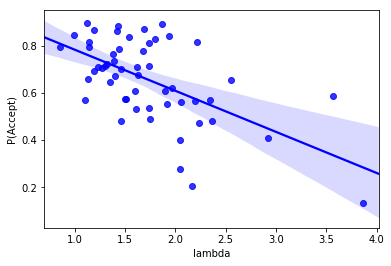

In [16]:
sns.regplot(allParticipantLambdas, allParticipants_p_accept, color ='blue')
plt.xlabel("lambda")
plt.ylabel("P(Accept)")
print("Pearson correlation between Lambda and P(Acceptance) is: ", pearsonr(allParticipantLambdas, allParticipants_p_accept))

('Pearson correlation between gamma and P(Acceptance) is: ', (-0.3243530523141497, 0.016719783438069194))


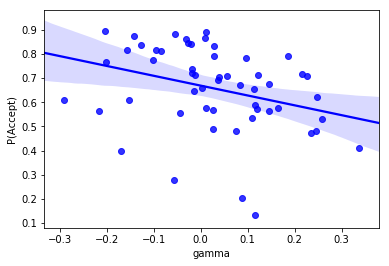

In [17]:
sns.regplot(allParticipantsZ, allParticipants_p_accept, color ='blue')
plt.xlabel("gamma")
plt.ylabel("P(Accept)")
print("Pearson correlation between gamma and P(Acceptance) is: ", pearsonr(allParticipantsZ, allParticipants_p_accept))

('Pearson correlation between alpha and P(Acceptance) is: ', (0.5686647833470619, 7.252296921896888e-06))


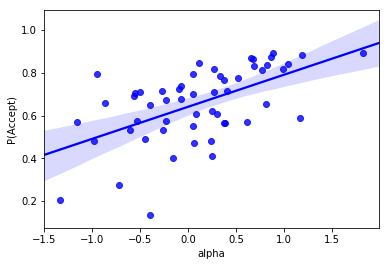

In [18]:
sns.regplot(allParticipantsAlphas, allParticipants_p_accept, color ='blue')
plt.xlabel("alpha")
plt.ylabel("P(Accept)")
print("Pearson correlation between alpha and P(Acceptance) is: ", pearsonr(allParticipantsAlphas, allParticipants_p_accept))

# Correlation with lambda (traditional method -- computed using logistic regression)

In [20]:
import matplotlib
matplotlib.rcParams.update({'font.size': 30})

In [21]:
from sklearn.linear_model import LogisticRegression
allSubjectsIndex = np.array(allSubjectsIndex)
indicesToAnalyze = allSubjectsIndex[allParticipants_p_accept[:] != 0]

def computeParticipantLambdaLR(subjectIndex):
    participantData = data[data['subj_idx'] == subjectIndex]
    X = participantData[['gain', 'loss']]
    y = participantData['response']
    classifier = LogisticRegression(fit_intercept=True).fit(X, y)
    coefficients = classifier.coef_
    participantLambdaLR = coefficients[0][1]/coefficients[0][0]
    return participantLambdaLR

allParticipantLambdasLR = [computeParticipantLambdaLR(_) for _ in indicesToAnalyze]

/anaconda3/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [22]:
print("Lambda computed using logistic regression, mean: {}, SD: {}".format(np.mean(allParticipantLambdasLR), np.std(allParticipantLambdasLR)))

Lambda computed using logistic regression, mean: 1.60213053837, SD: 0.67404260028


(array([ 0.,  6., 25., 13.,  7.,  0.,  2.,  0.,  0.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5]),
 <a list of 9 Patch objects>)

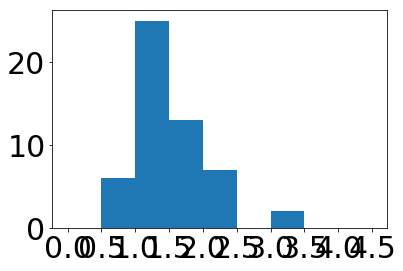

In [23]:
from matplotlib import pyplot as plt
plt.xticks(np.arange(0, 5, 0.5))
plt.hist(allParticipantLambdasLR, np.arange(0, 5, 0.5))

('Pearson correlation between P(accept) and Logistic regression lambda is: ', (-0.8223109862350477, 2.4569801355778784e-14))


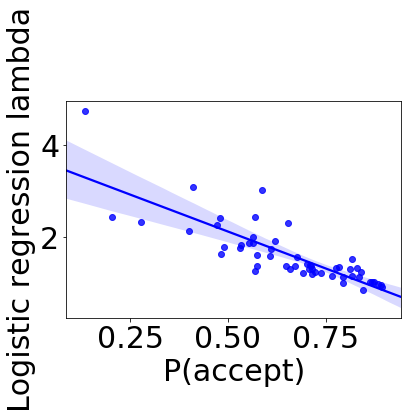

In [24]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# pAcceptToCorrelate = np.array(allParticipants_p_accept)[indicesToAnalyze]
sns.regplot(allParticipants_p_accept, allParticipantLambdasLR, color ='blue')
plt.xlabel("P(accept)")
plt.ylabel("Logistic regression lambda")
print("Pearson correlation between P(accept) and Logistic regression lambda is: ", pearsonr(allParticipants_p_accept, allParticipantLambdasLR))

('Pearson correlation between DDM lambda and Logistic regression lambda is: ', (0.8988790704340531, 2.8382792750839094e-20))


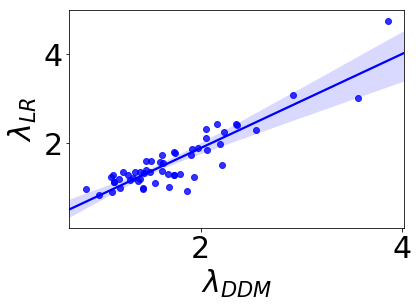

In [25]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# lambdasToCorrelate = np.array(allParticipantLambdas)[indicesToAnalyze]
sns.regplot(allParticipantLambdas, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\lambda_{DDM}$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between DDM lambda and Logistic regression lambda is: ", pearsonr(allParticipantLambdas, allParticipantLambdasLR))

('Pearson correlation between gamma and Logistic regression lambda is: ', (0.3599151592701559, 0.007513772847873939))


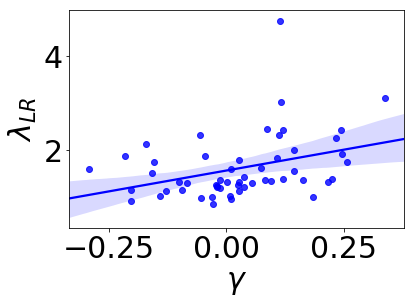

In [26]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# gammasToCorrelate = np.array(allParticipantsZ)[indicesToAnalyze]
sns.regplot(allParticipantsZ, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\gamma$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between gamma and Logistic regression lambda is: ", pearsonr(allParticipantsZ, allParticipantLambdasLR))

('Pearson correlation between alpha and Logistic regression lambda is: ', (-0.14111987966769193, 0.30874681863370906))


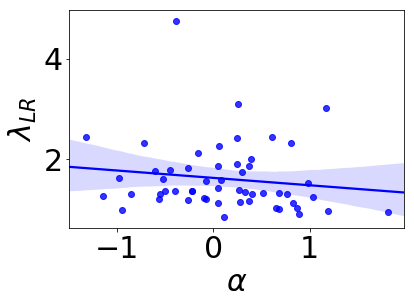

In [27]:
# fig=plt.figure(figsize=(8,8), dpi= 100, facecolor='w', edgecolor='k')
# alphasToCorrelate = np.array(allParticipantsAlphas)[indicesToAnalyze]
sns.regplot(allParticipantsAlphas, allParticipantLambdasLR, color ='blue')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\lambda_{LR}$")
print("Pearson correlation between alpha and Logistic regression lambda is: ", pearsonr(allParticipantsAlphas, allParticipantLambdasLR))

In [28]:
from scipy import stats
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore
import pandas as pd

y = np.reshape(allParticipantLambdasLR, (-1, 1))
X = np.vstack((allParticipantLambdas, allParticipantsZ, allParticipantsAlphas)).T
# X = np.vstack((allParticipantLambdas, allParticipantsZ, allParticipantsAlphas)).T

combined = np.hstack((y, zscore(X)))
df = pd.DataFrame(combined)
df.columns = ['y', 'x1', 'x2', 'x3']
df_z = df.select_dtypes(include=[np.number]).dropna()#.apply(stats.zscore)


formula = 'y ~ x1 + x2 + x3'
result = smf.ols(formula, data=df_z).fit()
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                     314.1
Date:                Thu, 31 Dec 2020   Prob (F-statistic):           2.01e-32
Time:                        00:43:45   Log-Likelihood:                 25.358
No. Observations:                  54   AIC:                            -42.72
Df Residuals:                      50   BIC:                            -34.76
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6021      0.021     74.879      0.000       1.559       1.645
x1             0.6699      0.024     28.473      0.000       0.623       0.717
x2             0.0030      0.023      0.126      0.900      -0.044       0.050
x3            -0.2609      0.023    -11.159      0.000      -0.308      -0.214
==============================================================================
Omnibus:                        3.541   Durbin-Watson:                   1.552
Prob(Omnibus):                  0.170   Jarque-Bera (JB):                2.541
Skew:                           0.406   Prob(JB):                        0.281
Kurtosis:                       3.686   Cond. No.                         1.59
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Simulate data from model

In [5]:
ppc_data = hddm.utils.post_pred_gen(m, samples=50, progress_bar=True)

 [------------------105%------------------] 57 of 54 complete in 16088.8 sec

In [6]:
import numpy as np
dataArray = np.genfromtxt("data_preprocessed.csv", delimiter=',')
dataArray = dataArray[1:, 1:]

def extractStakesFromParticipantIndex(participantIndex):
    participantData = dataArray[dataArray[:, 0] == participantIndex][:]
    participantStakes = participantData[:, -2:]
    return participantStakes

In [7]:
import numpy as np

overallData = np.zeros((1, 5))

for (node, sample), sim_data in ppc_data.groupby(level=(0, 1)):
    print("-------")
    print("node: ", node)
    sim_data_array = np.asarray(sim_data)
    numTrials = np.shape(sim_data_array)[0]
    print("number of trials: ", numTrials)
    participantIndex = int(filter(str.isdigit, node))
    participantStakes = extractStakesFromParticipantIndex(participantIndex)
    participantIndexArray = np.full((numTrials, 1), participantIndex)
    responsesArray = np.zeros((numTrials, 1))
    responsesArray[sim_data_array[:, 0] > 0] = 1
    reactionTimesArray = np.abs(sim_data_array)
    sim_data_modified = np.hstack((participantIndexArray, responsesArray, reactionTimesArray, participantStakes))
    overallData = np.vstack((overallData, sim_data_modified))
    
print(np.shape(overallData))

-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('number of trials: ', 255)
-------
('node: ', 'wfpt.1')
('

-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 252)
-------
('node: ', 'wfpt.107')
('number of trials: ', 25

-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 255)
-------
('node: ', 'wfpt.113')
('number of trials: ', 25

-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 250)
-------
('node: ', 'wfpt.119')
('number of trials: ', 25

-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node: ', 'wfpt.13')
('number of trials: ', 256)
-------
('node

-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node: ', 'wfpt.19')
('number of trials: ', 255)
-------
('node

-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node: ', 'wfpt.27')
('number of trials: ', 256)
-------
('node

-------
('node: ', 'wfpt.3')
('number of trials: ', 246)
-------
('node: ', 'wfpt.3')
('number of trials: ', 246)
-------
('node: ', 'wfpt.3')
('number of trials: ', 246)
-------
('node: ', 'wfpt.3')
('number of trials: ', 246)
-------
('node: ', 'wfpt.3')
('number of trials: ', 246)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 'wfpt.33')
('number of trials: ', 253)
-------
('node: ', 

-------
('node: ', 'wfpt.37')
('number of trials: ', 247)
-------
('node: ', 'wfpt.37')
('number of trials: ', 247)
-------
('node: ', 'wfpt.37')
('number of trials: ', 247)
-------
('node: ', 'wfpt.37')
('number of trials: ', 247)
-------
('node: ', 'wfpt.37')
('number of trials: ', 247)
-------
('node: ', 'wfpt.37')
('number of trials: ', 247)
-------
('node: ', 'wfpt.37')
('number of trials: ', 247)
-------
('node: ', 'wfpt.37')
('number of trials: ', 247)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node: ', 'wfpt.39')
('number of trials: ', 256)
-------
('node

-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.43')
('number of trials: ', 256)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node: ', 'wfpt.45')
('number of trials: ', 254)
-------
('node

-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node: ', 'wfpt.49')
('number of trials: ', 255)
-------
('node

-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node: ', 'wfpt.53')
('number of trials: ', 256)
-------
('node

-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node: ', 'wfpt.59')
('number of trials: ', 256)
-------
('node

-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node: ', 'wfpt.67')
('number of trials: ', 254)
-------
('node

-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node: ', 'wfpt.73')
('number of trials: ', 245)
-------
('node

-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node: ', 'wfpt.79')
('number of trials: ', 256)
-------
('node

-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node: ', 'wfpt.85')
('number of trials: ', 255)
-------
('node

-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('number of trials: ', 255)
-------
('node: ', 'wfpt.9')
('

-------
('node: ', 'wfpt.95')
('number of trials: ', 251)
-------
('node: ', 'wfpt.95')
('number of trials: ', 251)
-------
('node: ', 'wfpt.95')
('number of trials: ', 251)
-------
('node: ', 'wfpt.95')
('number of trials: ', 251)
-------
('node: ', 'wfpt.95')
('number of trials: ', 251)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node: ', 'wfpt.99')
('number of trials: ', 256)
-------
('node

In [8]:
import pandas as pd

modelName = 'fullModel'

import os
if not os.path.exists('simulatedData/{}'.format(modelName)):
    os.makedirs('simulatedData/{}'.format(modelName))


df = pd.DataFrame(overallData[1:, :])
df.columns = ['subj_idx', 'response', 'rt', 'gain', 'loss']
df.to_csv('simulatedData/{}/{}.csv'.format(modelName, modelName))
# np.savetxt("simulatedData.csv", overallData, delimiter=",", fmt='%.5f')

In [13]:
df.head()

,subj_idx,response,rt,gain,loss
0,10.0,1.0,4.354844,11.0,-11.0
1,10.0,1.0,3.377044,17.0,-16.0
2,10.0,1.0,1.430044,18.0,-12.0
3,10.0,1.0,1.225444,20.0,-15.0
4,10.0,1.0,1.422044,17.0,-8.0
